### 1. Preliminaries

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

In [23]:
PATH_CLUSTERS = '../Results/clusters_v2/'
PATH_CLUSTERS2 = '../Results/clusters_v3/'
PATH_CLUSTERS3 = '../Results/clusters_v4/'
PATH_ANOM = "/net/pc230050/nobackup/users/duinen/LENTIS/present/zg500_anomaly/"
PATH_ZG500 = "/net/pc230050/nobackup/users/duinen/LENTIS/present/zg500_d/"

all_files = [f"{PATH_CLUSTERS}clusters_{i}.csv" for i in range(10, 170)] 
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
df.to_csv(f"{PATH_CLUSTERS}clusters_all.csv") # save concatenated dataframe to csv. All that is needed to continue with 03.

In [3]:
all_files2 = [f"{PATH_CLUSTERS2}clusters_{i}.csv" for i in range(10, 170)] 
df2 = pd.concat((pd.read_csv(f) for f in all_files2), ignore_index=True)
#df.to_csv(f"{PATH_CLUSTERS}clusters_all.csv") # save concatenated dataframe to csv. All that is needed to continue with 03.

In [24]:
all_files3 = [f"{PATH_CLUSTERS3}clusters_{i}.csv" for i in range(10, 170)] 
df3 = pd.concat((pd.read_csv(f) for f in all_files3), ignore_index=True)

### 2. Defining functions

In [42]:
# # Add a new column for cluster persistency
# df['persistency'] = 1

# # Iterate over the rows to calculate persistency
# current_cluster = None
# persistency_count = 1

# for index, row in df.iterrows():
#     if current_cluster is None:
#         current_cluster = row['cluster_id']
#     else:
#         if row['cluster_id'] == current_cluster:
#             persistency_count += 1
#         else:
#             persistency_count = 1
#             current_cluster = row['cluster_id']
    
#     df.at[index, 'persistency'] = persistency_count

In [4]:
def calculate_persistency_stats(df, date_col='time', cluster_col='cluster_id'):
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Calculate the difference in days within each cluster
    df['date_diff'] = df.groupby(cluster_col)[date_col].diff().dt.days
    df['new_streak'] = (df['date_diff'] != 1)
    
    # Create a new group identifier for each streak
    df['streak_id'] = df.groupby(cluster_col)['new_streak'].cumsum()
    
    # Calculate the length of each streak
    streak_lengths = df.groupby([cluster_col, 'streak_id']).size().reset_index(name='streak_length')
    
    # Calculate the average, median, standard deviation, and maximum persistency
    persistency_stats = streak_lengths.groupby(cluster_col).agg(['mean', 'median', 'std', 'max'])
    
    return persistency_stats, streak_lengths

In [44]:
def handle_deviations(df):
    df2 = df.copy()
    # Identify indices where date_diff is 2 and the next two date_diffs are 1
    indices = df.index[(df['date_diff'] == 2) & (df['date_diff'].shift(-1) == 1) & (df['date_diff'].shift(-2) == 1)]
    
    # Change the cluster_id for these indices to the cluster_id of the previous index
    for i in indices:
        df2.loc[i-1, 'cluster_id'] = df.loc[i-2, 'cluster_id']
    return df2

#### Plotting functions

In [45]:
def plot_all_clusters(df, run):
    fig, axs = plt.subplots(2, 3, figsize=(20, 12),
                            subplot_kw={'projection': ccrs.Orthographic(central_longitude=-30, central_latitude=50)})

    for i, ax in enumerate(axs.flat):
        if i == 5:  # Adjust the condition to handle less than 6 clusters
            ax.axis('off')  # Turn off the axes for empty subplots
            continue
        else:
            cluster_id = i
            mask = (df['run'] == run) & (df['cluster_id'] == cluster_id)
            times = df.loc[mask, 'time']

            filename_anom = f"{PATH_ANOM}anom_zg500_d_ECEarth3_h{run:03d}.nc"
            filename = f"{PATH_ZG500}zg500_d_ECEarth3_h{run:03d}.nc"
            ds = xr.open_dataset(filename_anom)
            ds_full = xr.open_dataset(filename)

            ds = ds.where(
                (ds['time'].dt.month.isin([12, 1, 2])) &
                (ds['lon'] < 30) &
                (ds['lat'] > 20) &
                (ds['lat'] < 80),
                drop=True
            )

            ds_full = ds_full.where(
                (ds_full['time'].dt.month.isin([12, 1, 2])) &
                (ds_full['lon'] < 30) &
                (ds_full['lat'] > 20) &
                (ds_full['lat'] < 80),
                drop=True
            )

            vals = ds.sel(time = times.tolist()).zg500.mean(dim = 'time').values
            vals_contour = ds_full.sel(time = times.tolist()).zg500.mean(dim = 'time').values
            min_val = np.floor(np.min(vals_contour) / 100) * 100
            max_val = np.ceil(np.max(vals_contour) / 100) * 100

            levels = np.arange(min_val, max_val, 100)
            lons = ds.zg500['lon'].values
            lats = ds.zg500['lat'].values

            fill = ax.contourf(
                lons,
                lats,
                vals,
                levels = np.linspace(-200, 200, 41),
                cmap=plt.cm.RdBu_r,
                extend = 'both',
                transform=ccrs.PlateCarree())

            cs = ax.contour(
                lons,
                lats,
                vals_contour,
                levels = levels,
                transform = ccrs.PlateCarree(),
                colors = 'k'
            )

            ax.clabel(cs, inline=True, fontsize=10)

            cb = plt.colorbar(fill,
                            orientation='vertical',
                            label='500 hPa height anomaly [m]',
                            extend='both',
                            ax=ax)
            ax.coastlines(resolution='50m')
            ax.gridlines()
            ax.set_title(f"Cluster {cluster_id}")

    plt.tight_layout()
    plt.show()

In [46]:
def plot_correlating_clusters(df, run, corr_min, corr_max):
    fig, axs = plt.subplots(2, 2, figsize=(13, 8),
                            subplot_kw={'projection': ccrs.Orthographic(central_longitude=-30, central_latitude=50)})

    for i, ax in enumerate(axs.flat):
        cluster_id = i
        mask = (df['run'] == run) & (df['cluster_id'] == cluster_id) & (df['correlation'] >= corr_min) & (df['correlation'] <= corr_max)
        times = df.loc[mask, 'time']

        filename_anom = f"{PATH_ANOM}anom_zg500_d_ECEarth3_h{run:03d}.nc"
        filename = f"{PATH_ZG500}zg500_d_ECEarth3_h{run:03d}.nc"
        ds = xr.open_dataset(filename_anom)
        ds_full = xr.open_dataset(filename)

        ds = ds.where(
            (ds['time'].dt.month.isin([12, 1, 2])) &
            (ds['lon'] < 30) &
            (ds['lat'] > 20) &
            (ds['lat'] < 80),
            drop=True
        )

        ds_full = ds_full.where(
            (ds_full['time'].dt.month.isin([12, 1, 2])) &
            (ds_full['lon'] < 30) &
            (ds_full['lat'] > 20) &
            (ds_full['lat'] < 80),
            drop=True
        )
        if len(times) > 0:
            vals = ds.sel(time = times.tolist()).zg500.mean(dim = 'time').values
            vals_contour = ds_full.sel(time = times.tolist()).zg500.mean(dim = 'time').values
            min_val = np.floor(np.min(vals_contour) / 100) * 100
            max_val = np.ceil(np.max(vals_contour) / 100) * 100

            levels = np.arange(min_val, max_val, 100)
            lons = ds.zg500['lon'].values
            lats = ds.zg500['lat'].values

            fill = ax.contourf(
                lons,
                lats,
                vals,
                levels = np.linspace(-200, 200, 41),
                cmap=plt.cm.RdBu_r,
                extend = 'both',
                transform=ccrs.PlateCarree())

            cs = ax.contour(
                lons,
                lats,
                vals_contour,
                levels = levels,
                transform = ccrs.PlateCarree(),
                colors = 'k'
            )

            ax.clabel(cs, inline=True, fontsize=10)

            cb = plt.colorbar(fill,
                            orientation='vertical',
                            label='500 hPa height anomaly [m]',
                            extend='both',
                            ax=ax)
            ax.coastlines(resolution='50m')
            ax.gridlines()
            ax.set_title(f"Cluster {cluster_id}")

    plt.tight_layout()
    plt.show()

### 3. Checking cluster statistics

In [25]:
pers_stats, streak_lengths = calculate_persistency_stats(df)
pers_stats2, streak_lengths2 = calculate_persistency_stats(df2)
pers_stats3, streak_lengths3 = calculate_persistency_stats(df3)

In [33]:
pers_stats2

streak_id                             streak_length         \
                mean  median          std    max          mean median   
cluster_id                                                              
0             4652.0  4652.0  2685.689111   9303      6.125228    5.0   
1             4381.0  4381.0  2529.227188   8761      8.965986    7.0   
2             5234.5  5234.5  3021.995643  10468      8.539931    6.0   
3             5166.5  5166.5  2982.735825  10332      6.515002    5.0   
4             8944.0  8944.0  5163.676468  17887      2.652038    2.0   

                          
                 std max  
cluster_id                
0           4.763636  47  
1           7.549198  90  
2           7.397116  87  
3           4.866475  50  
4           2.225922  20

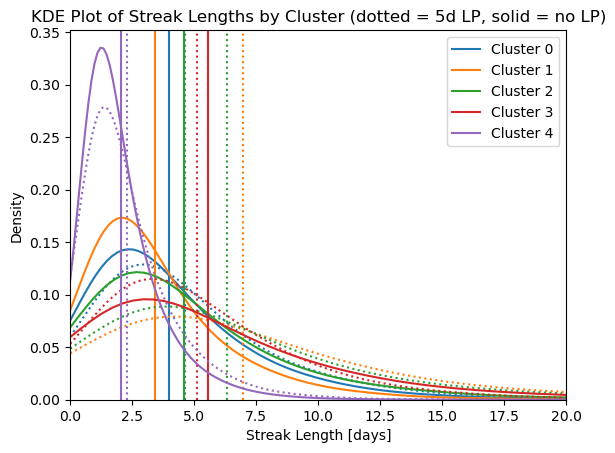

In [27]:
colors = ['C0', 'C1', 'C2', 'C3', 'C4']

for cluster_id in range(5):
    color = colors[cluster_id]
    cluster_data3 = streak_lengths3[streak_lengths3['cluster_id'] == cluster_id]['streak_length']
    plt.axvline(np.mean(cluster_data3), color = color)
    cluster_data = streak_lengths[streak_lengths['cluster_id'] == cluster_id]['streak_length']
    plt.axvline(np.mean(cluster_data), color = color, linestyle = 'dotted')
    sns.kdeplot(cluster_data3, color = color, label=f'Cluster {cluster_id}', bw_method=0.5, clip = (0, 100))
    sns.kdeplot(cluster_data, color = color, linestyle="dotted", bw_method=0.5, clip = (0, 100))

# Add labels and title
plt.xlabel('Streak Length [days]')
plt.ylabel('Density')
plt.title('KDE Plot of Streak Lengths by Cluster (dotted = 5d LP, solid = no LP)')
plt.xlim(0, 20)
plt.legend()

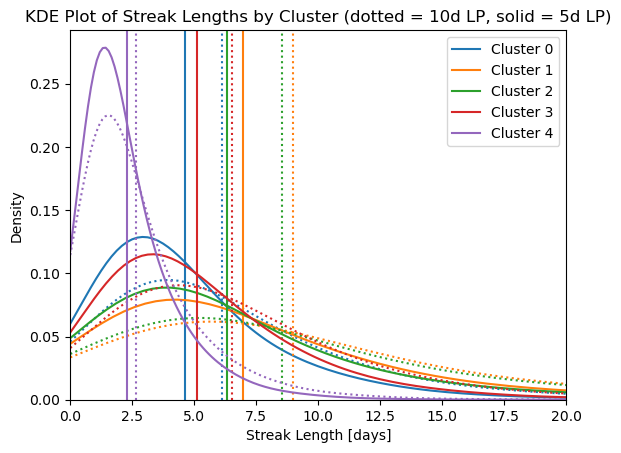

In [22]:
# Plot KDE plots for each cluster with different colors
for cluster_id in range(5):
    color = colors[cluster_id]
    cluster_data = streak_lengths[streak_lengths['cluster_id'] == cluster_id]['streak_length']
    plt.axvline(np.mean(cluster_data), color = color)
    cluster_data2 = streak_lengths2[streak_lengths2['cluster_id'] == cluster_id]['streak_length']
    plt.axvline(np.mean(cluster_data2), color = color, linestyle = 'dotted')
    sns.kdeplot(cluster_data, color = color, label=f'Cluster {cluster_id}', bw_method=0.5, clip = (0, 100))
    sns.kdeplot(cluster_data2, color = color, linestyle="dotted", bw_method=0.5, clip = (0, 100))

# Add labels and title
plt.xlabel('Streak Length [days]')
plt.ylabel('Density')
plt.title('KDE Plot of Streak Lengths by Cluster (dotted = 10d LP, solid = 5d LP)')
plt.xlim(0, 20)
plt.legend()

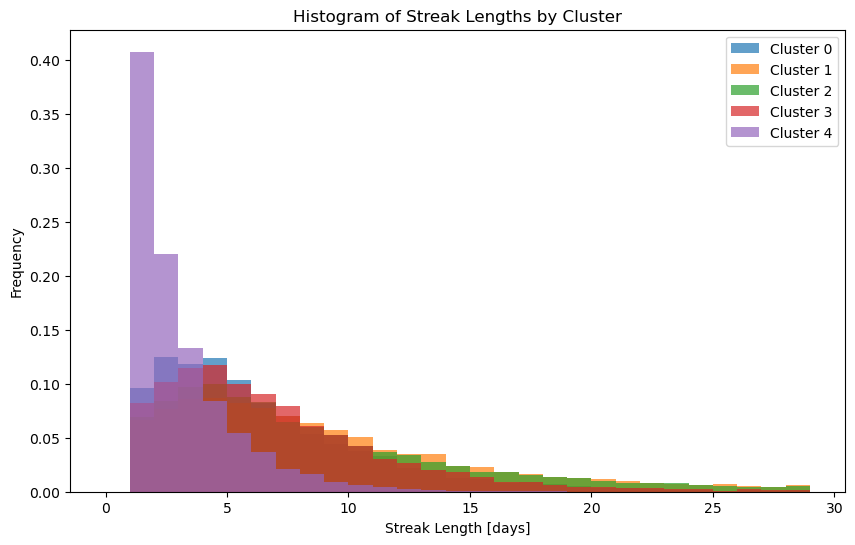

In [28]:
# Set up the figure and axis
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot histograms for each cluster with different colors
for cluster_id in range(5):
    cluster_data2 = streak_lengths2[streak_lengths2['cluster_id'] == cluster_id]['streak_length']
    plt.hist(cluster_data2, bins=np.arange(30), alpha=0.7, label=f'Cluster {cluster_id}', density=True)

# Add labels and title
plt.xlabel('Streak Length [days]')
plt.ylabel('Frequency')
plt.title('Histogram of Streak Lengths by Cluster')
plt.legend()

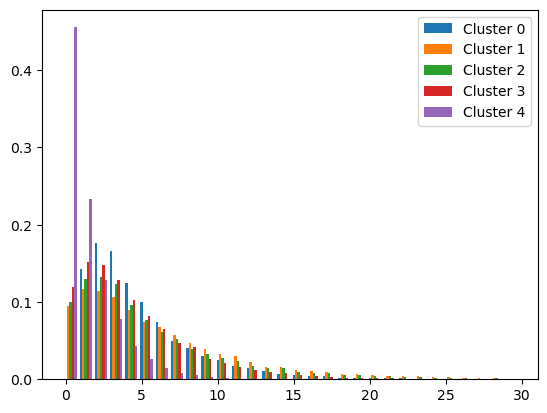

In [55]:
# Plot histograms for each cluster with different colors
width = 0.8 / 5  # Adjust the width of each bar
for cluster_id in range(5):
    cluster_data = streak_lengths[streak_lengths['cluster_id'] == cluster_id]['streak_length']
    bins = np.arange(30) - 0.5 * width + cluster_id * width
    plt.hist(cluster_data, bins=bins, width=width, label=f'Cluster {cluster_id}', align='mid', density=True)


# Show the legend
plt.legend(loc='upper right')

(array([16173., 12559.,  9965.,  7827.,  5839.,  4443.,  3364.,  2623.,
         2093.,  1609.,  1261.,  1071.,   772.,   583.,   542.,   381.,
          322.,   281.,   213.,   188.,   143.,   142.,   111.,    84.,
           75.,    61.,    51.,    73.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29.]),
 <BarContainer object of 28 artists>)

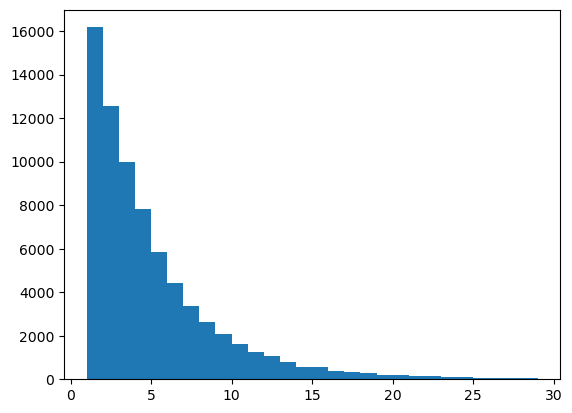

In [50]:
plt.hist(streak_lengths['streak_length'], bins = np.arange(1, 30))

(array([1.723e+03, 2.137e+03, 2.007e+03, 1.502e+03, 1.215e+03, 8.880e+02,
        6.000e+02, 4.890e+02, 3.630e+02, 3.020e+02, 2.000e+02, 1.800e+02,
        1.220e+02, 8.400e+01, 6.000e+01, 5.400e+01, 4.500e+01, 2.100e+01,
        2.100e+01, 1.900e+01, 1.700e+01, 1.300e+01, 5.000e+00, 1.000e+00,
        2.000e+00, 3.000e+00, 0.000e+00, 2.000e+00]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29.]),
 <BarContainer object of 28 artists>)

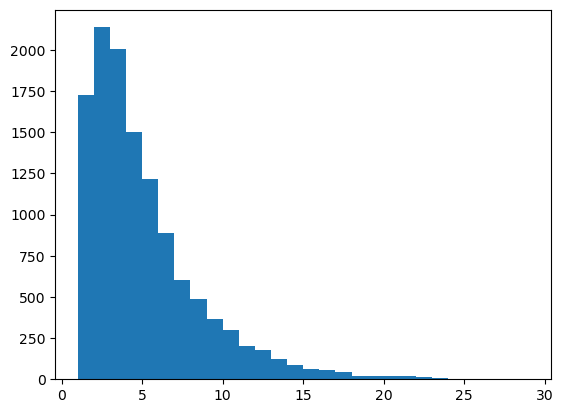

In [49]:
plt.hist(streak_lengths.query('cluster_id == 0')['streak_length'], bins = np.arange(1, 30))

In [10]:
pers_stats

mean  median       std  max
cluster_id                                 
0           4.616308     4.0  3.573974   36
1           6.960626     5.0  5.900344   77
2           6.312253     5.0  5.487957   65
3           5.121750     4.0  3.905173   42
4           2.289988     2.0  1.795241   21

In [13]:
#TODO: Not really using this yet. Maybe later.
df2 = handle_deviations(df)
pers_stats_2, streak_lengths_2 = calculate_persistency_stats(df2)

In [14]:
pers_stats_2

mean  median       std  max
cluster_id                                 
0           4.844182     4.0  3.772880   36
1           7.288753     6.0  6.187961   77
2           6.675261     5.0  5.863211   65
3           5.337868     4.0  4.069481   42
4           2.399607     2.0  1.986518   21

(array([    0., 23739., 19272., 11437.,  7863.,  5695.,  4416.,  3362.,
         2455.,  1903.,  1474.,  1113.,   896.,   655.,   529.,   420.,
          321.,   263.,   232.,   169.,   120.,   129.,   106.,   141.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.]),
 <BarContainer object of 24 artists>)

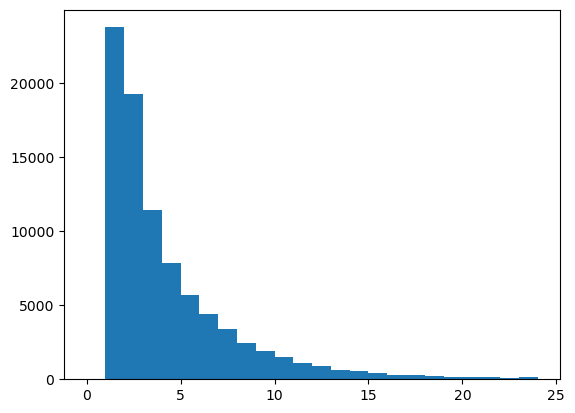

In [23]:
plt.hist(streak_lengths_2, bins = np.arange(25))

(array([55765., 77430., 86339., 67561., 52585.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <BarContainer object of 5 artists>)

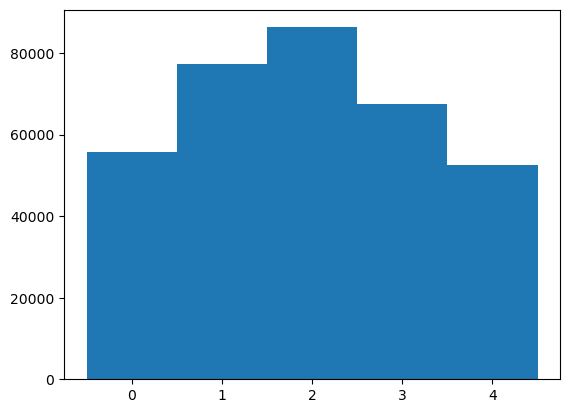

In [19]:
plt.hist(df['cluster_id'], bins = np.linspace(-.5, 4.5, 6))

In [20]:
for i in range(5):
    print(df.query('cluster_id == @i')['correlation'].mean(), df.query('cluster_id == @i')['correlation'].std())

0.5182618446307665 0.1359337399732501
0.5743753464869304 0.15092641109000815
0.5512697205330928 0.14591153360458903
0.5343365701467377 0.14032854441403048
0.20575735135792408 0.07577476119335662


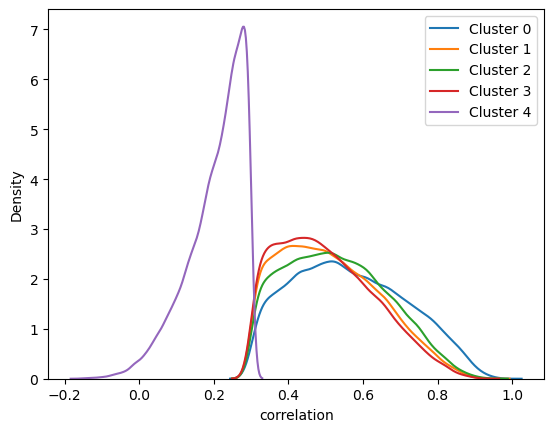

In [25]:
for i in range(5):
    sns.kdeplot(df.query('cluster_id == @i')['correlation'], label = f"Cluster {i}")
plt.legend()

### 4. Plot composites of regimes per run, to check if regimes are defined consistently.

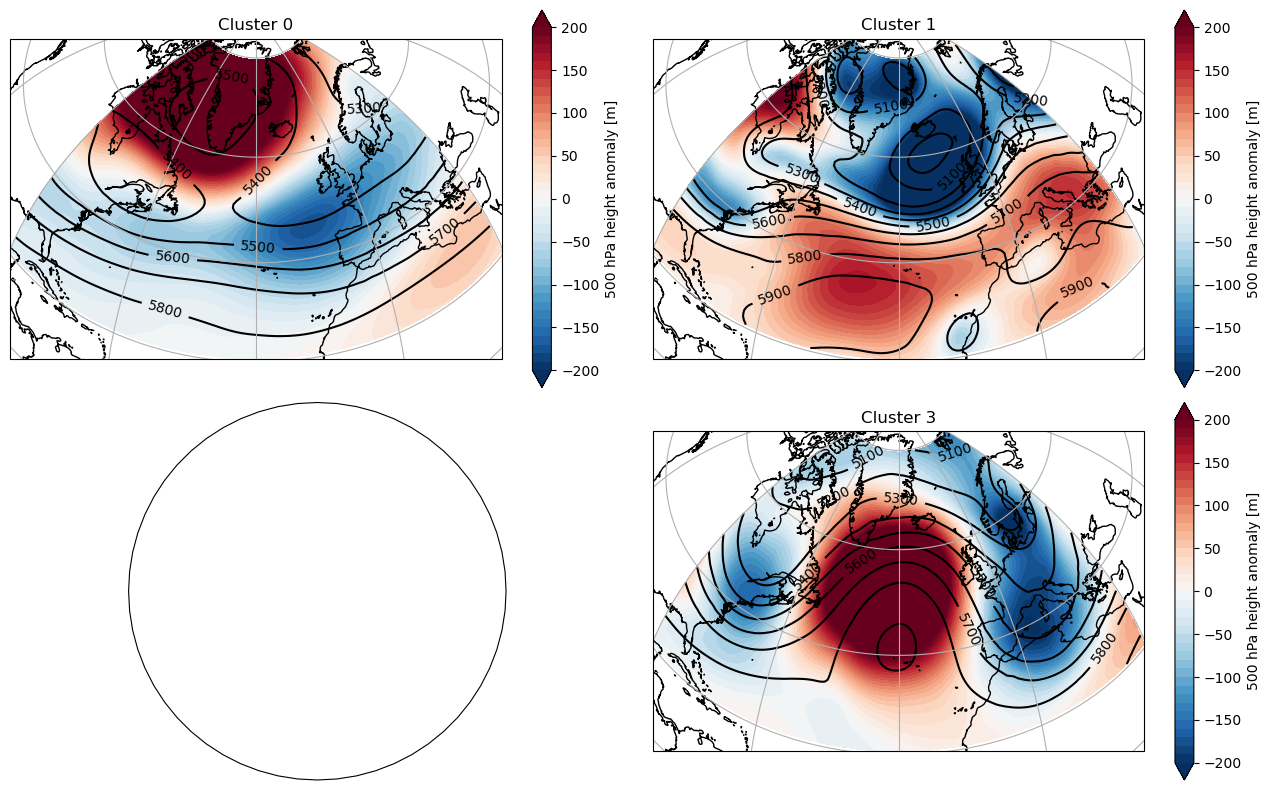

In [39]:
plot_correlating_clusters(df, 10, 0.8, 1)

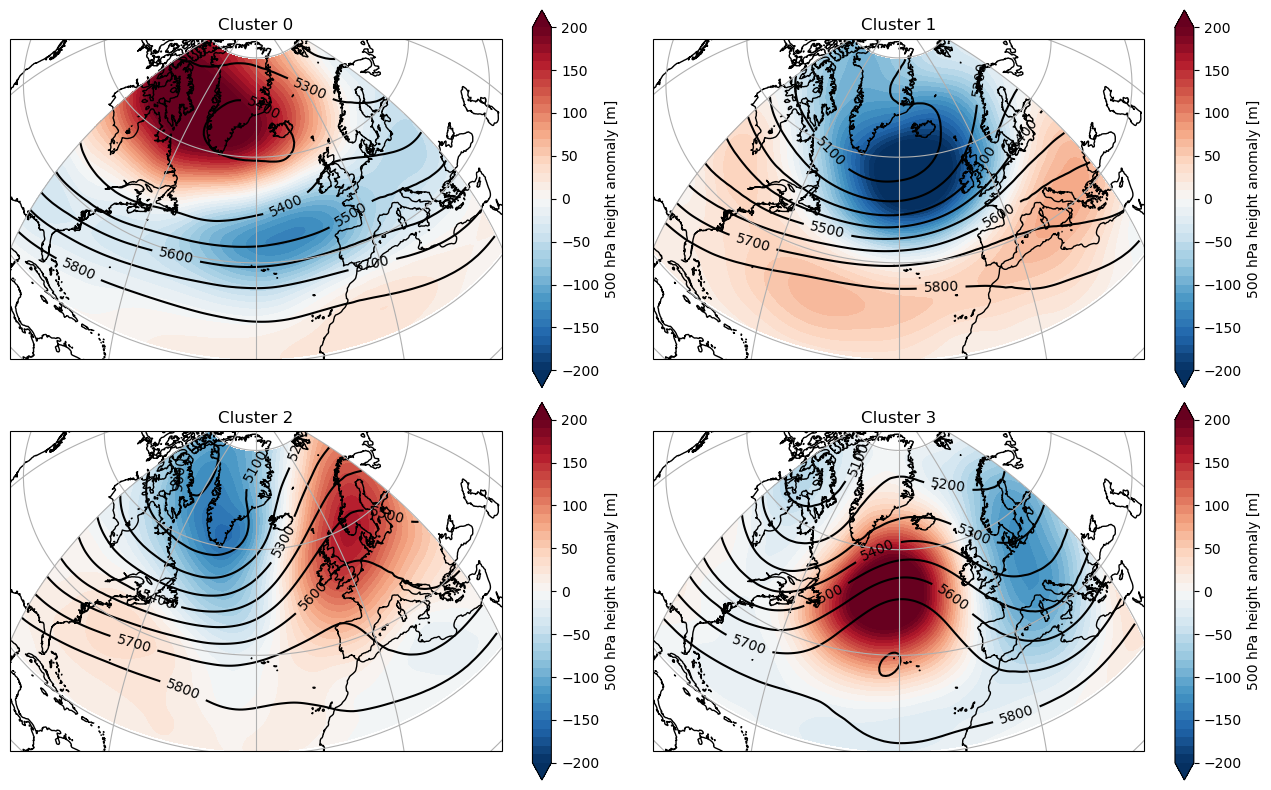

In [40]:
plot_correlating_clusters(df, 10, 0.5, 0.8)

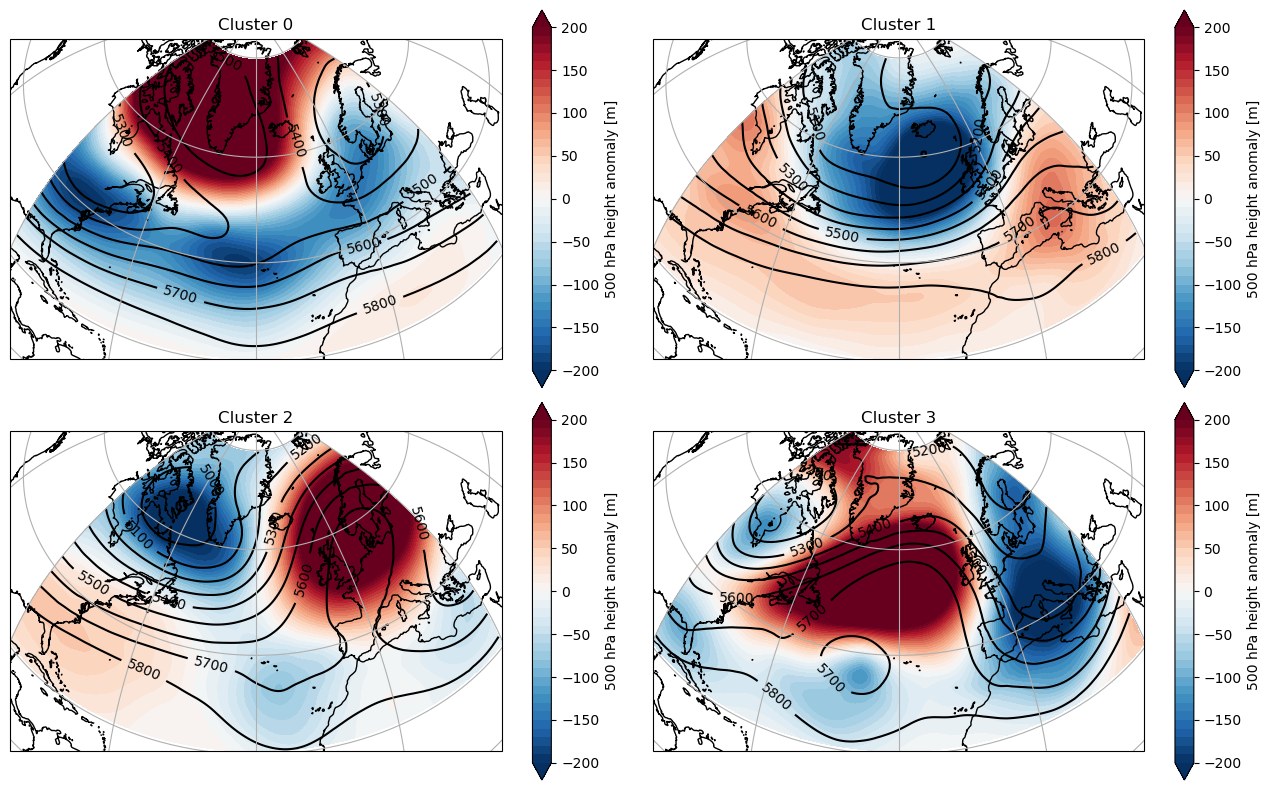

In [44]:
plot_correlating_clusters(df, 15, 0.8, 1)

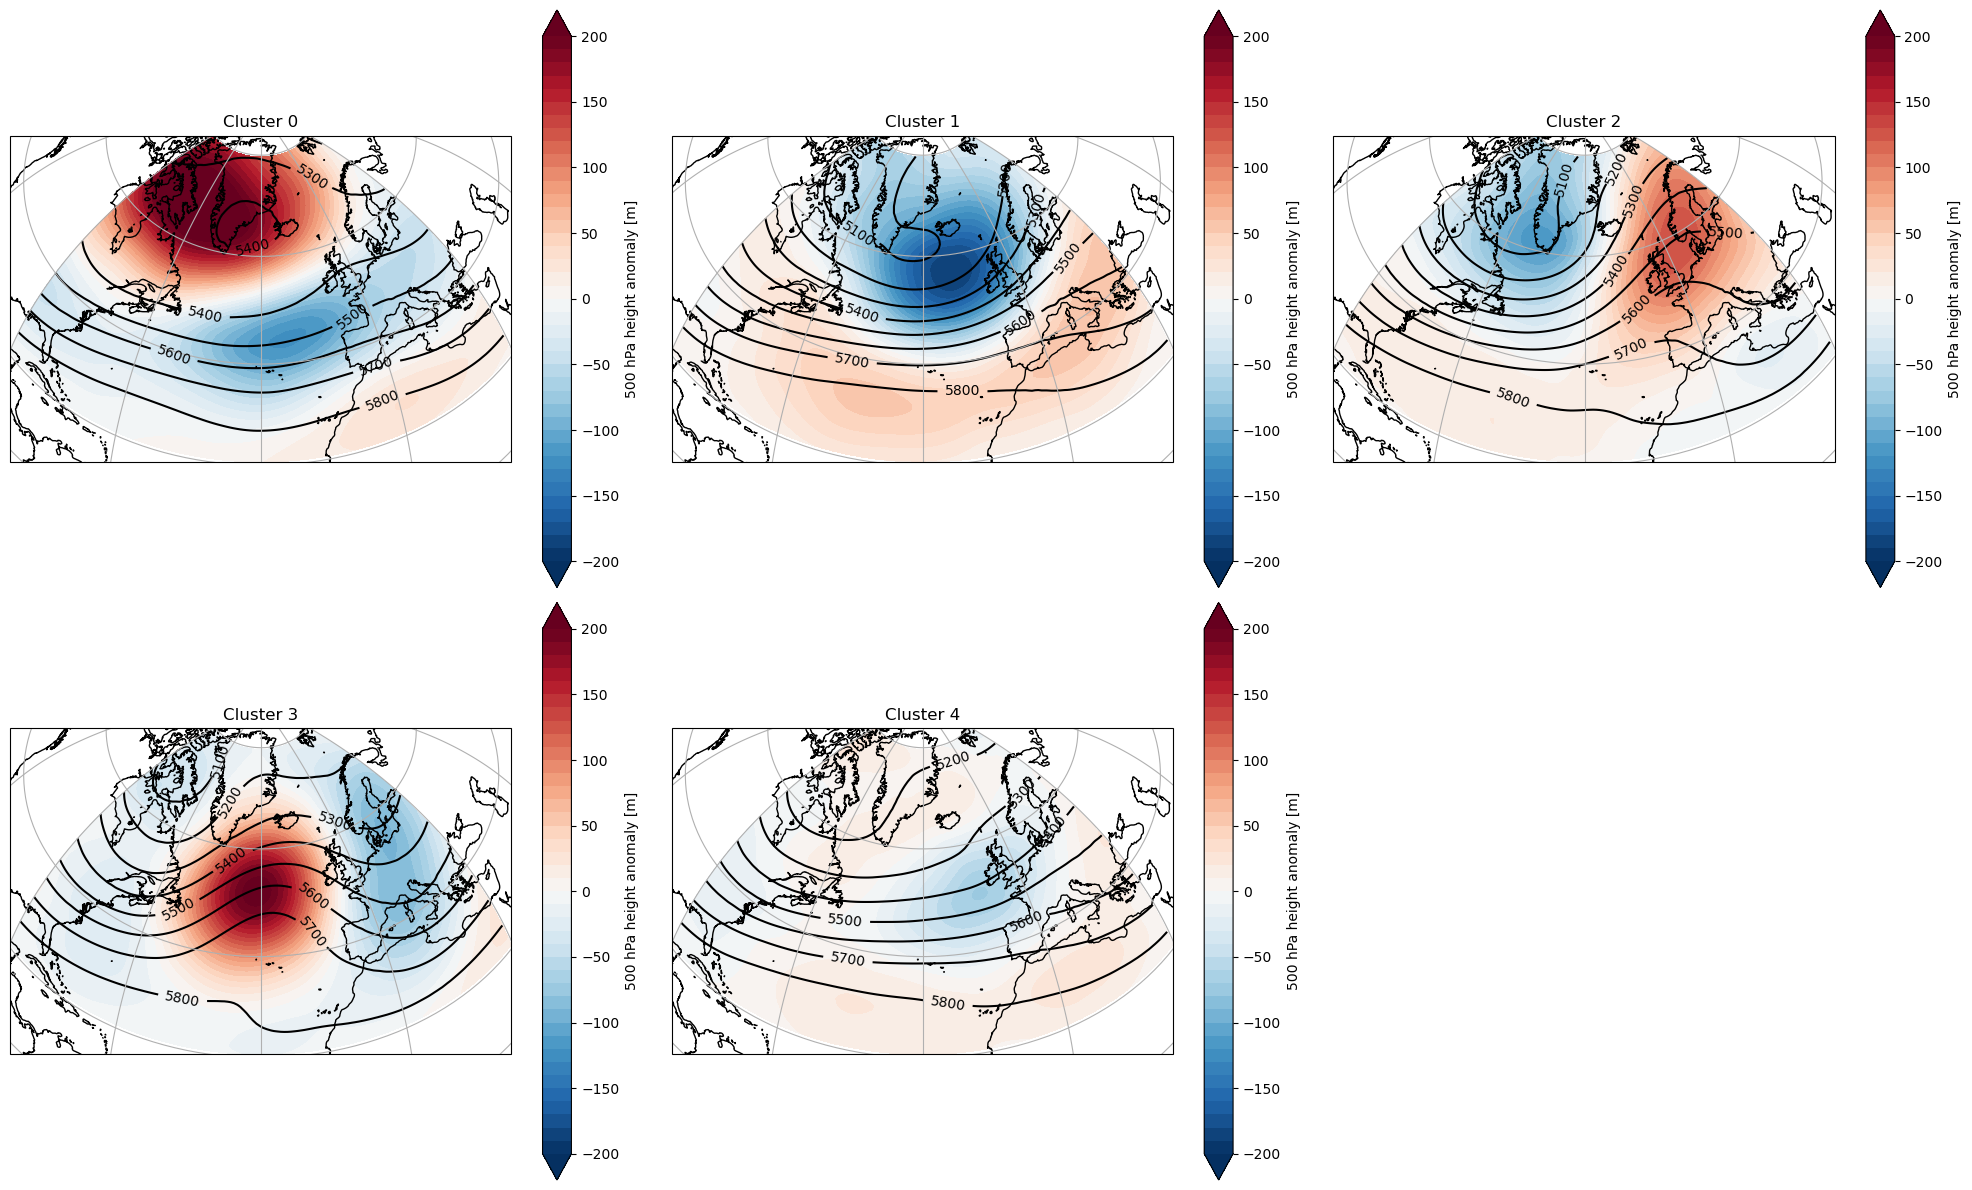

In [15]:
plot_all_clusters(df, 10)

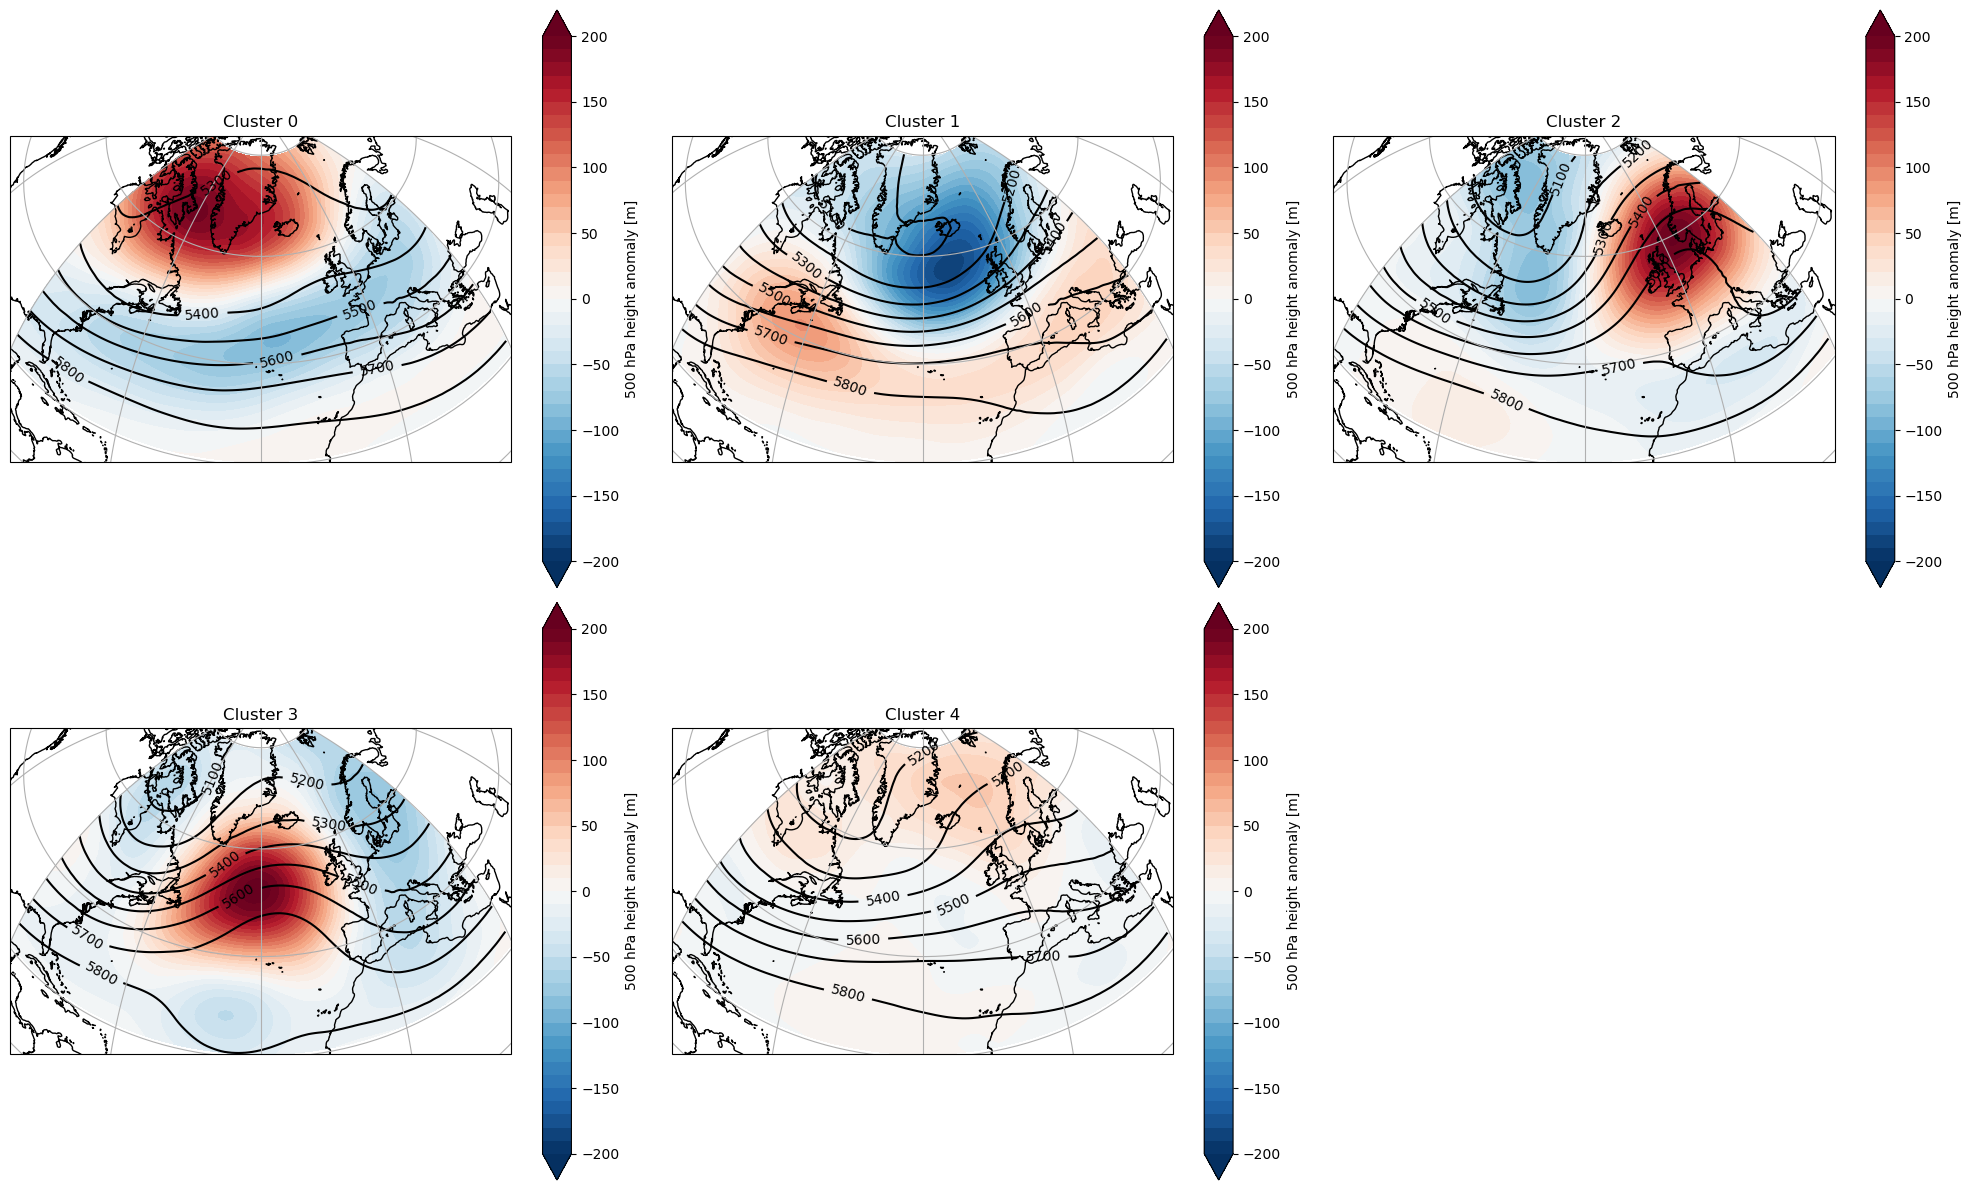

In [16]:
plot_all_clusters(df, 45)